# DM-31046 Zooniverse cutouts

This notebook is to try out the `ZoonverseCutoutsTask` implemented on DM-31046. The notebook may evolve as that task is improved (i.e. to include source selection via sql query) on a subsequent ticket.

In [1]:
import glob
import os
import pandas as pd
import sqlite3

import IPython.display

import lsst.daf.butler as dafButler
from lsst.pipe.tasks.zooniverseCutouts import ZooniverseCutoutsTask

import sys
sys.path.append('..')

# local to ap_pipe-notebooks
import apdbPlots as pla
import diaObjectAnalysis as doa

In [2]:
# The URL where the output files can be accessed by zooniverse.
url_root = "https://lsst.ncsa.illinois.edu/~ebellm/zooniverse/"
# The path to write the PNG and manifest files to.
output_path = "/scratch/ebellm/zooniverse/"

In [3]:
# gen 3, meredith's fakes run

In [4]:
repo = '/repo/main'
butler = dafButler.Butler(repo)

In [5]:
collection = 'u/mrawls/DM-31053-HSC-fakes'
dbSchema = 'mrawls_DM31053'
instrument = 'HSC'
skymap = 'hsc_rings_v1'

## Load sources from apdb

In [6]:
connection, tables = doa.connectToApdb('lsstdevapdb1', dbType='postgres', schema=dbSchema)

In [7]:
tables

{'obj': '"DiaObject"',
 'src': '"DiaSource"',
 'sso': '"SSObject"',
 'forcedsrc': '"DiaForcedSource"',
 'proto': '"ApdbProtoVisits"',
 'match': '"DiaObject_To_Object_Match"'}

In [7]:
%%time 
# to get a random sample: ORDER BY RANDOM() 
#sources = pd.read_sql_query(f'select * from {tables["src"]} LIMIT 100;', connection)
sources = pd.read_sql_query(f'select * from {tables["src"]} ORDER BY RANDOM() LIMIT 1000;', connection)

CPU times: user 78.7 ms, sys: 6.48 ms, total: 85.2 ms
Wall time: 16.6 s


In [8]:
sources

,diaSourceId,ccdVisitId,diaObjectId,ssObjectId,parentDiaSourceId,prv_procOrder,ssObjectReassocTime,midPointTai,ra,raErr,...,ixxPSF,iyyPSF,ixyPSF,extendedness,spuriousness,flags,pixelId,filterName,isDipole,bboxSize
0,5029464685674797,2342027,5029464685674797,0,0,0,None,56979.581706,149.771612,0.0,...,0.139825,0.004853,0.004853,0.0,0.0,328,0,g,False,28
1,5040670255349983,2347245,8452575095423158,0,0,0,None,56979.647636,149.410831,0.0,...,0.066785,0.001450,0.001450,0.0,0.0,25167144,0,y,False,25
2,13092885679309471,6096850,5027815418233229,0,0,0,None,57163.257755,149.885658,0.0,...,0.103256,0.000063,0.000063,0.0,0.0,568,0,i,True,31
3,535262446748054,249251,12594656588071262,0,0,0,None,56744.504393,149.640744,0.0,...,0.093470,0.008331,0.008331,0.0,0.0,1320,0,i,False,20
4,5042474141614597,2348085,5042474141614597,0,0,0,None,56979.655545,150.381108,0.0,...,0.102046,0.007207,0.007207,0.0,0.0,1384,0,y,False,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,149555056214312,69642,5028655084339762,0,0,0,None,56741.450108,149.986553,0.0,...,0.194700,0.002390,0.002390,0.0,0.0,1848,0,y,True,32
996,5037182741905997,2345621,5026015826936343,0,0,0,None,56979.631627,149.769583,0.0,...,0.099768,0.000005,0.000005,0.0,0.0,40,0,y,False,28
997,7707086884438927,3588892,12601642352378356,0,0,0,None,57038.603083,150.065912,0.0,...,0.051802,-0.003134,-0.003134,0.0,0.0,25297256,0,z,True,43
998,518067545178811,241244,518067545178811,0,0,0,None,56744.356494,149.641406,0.0,...,0.100998,0.005412,0.005412,0.0,0.0,25165824,0,r,False,17


In [9]:
# NOTE: need to run this to add ccd and visit identifiers to the sources.
# Apdb doesn't have another way to get those, and they are necessary for retrieving the images.
pla.addVisitCcdToSrcTable(sources, instrument=instrument, gen='gen3', butler=butler)

,diaSourceId,ccdVisitId,diaObjectId,ssObjectId,parentDiaSourceId,prv_procOrder,ssObjectReassocTime,midPointTai,ra,raErr,...,ixyPSF,extendedness,spuriousness,flags,pixelId,filterName,isDipole,bboxSize,visit,ccd
0,5029464685674797,2342027,5029464685674797,0,0,0,None,56979.581706,149.771612,0.0,...,0.004853,0.0,0.0,328,0,g,False,28,11710,27
1,5040670255349983,2347245,8452575095423158,0,0,0,None,56979.647636,149.410831,0.0,...,0.001450,0.0,0.0,25167144,0,y,False,25,11736,45
2,13092885679309471,6096850,5027815418233229,0,0,0,None,57163.257755,149.885658,0.0,...,0.000063,0.0,0.0,568,0,i,True,31,30484,50
3,535262446748054,249251,12594656588071262,0,0,0,None,56744.504393,149.640744,0.0,...,0.008331,0.0,0.0,1320,0,i,False,20,1246,51
4,5042474141614597,2348085,5042474141614597,0,0,0,None,56979.655545,150.381108,0.0,...,0.007207,0.0,0.0,1384,0,y,False,15,11740,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,149555056214312,69642,5028655084339762,0,0,0,None,56741.450108,149.986553,0.0,...,0.002390,0.0,0.0,1848,0,y,True,32,348,42
996,5037182741905997,2345621,5026015826936343,0,0,0,None,56979.631627,149.769583,0.0,...,0.000005,0.0,0.0,40,0,y,False,28,11728,21
997,7707086884438927,3588892,12601642352378356,0,0,0,None,57038.603083,150.065912,0.0,...,-0.003134,0.0,0.0,25297256,0,z,True,43,17944,92
998,518067545178811,241244,518067545178811,0,0,0,None,56744.356494,149.641406,0.0,...,0.005412,0.0,0.0,25165824,0,r,False,17,1206,44


In [10]:
sources['instrument'] = instrument


In [11]:
sources.to_csv(output_path + 'sources.csv')

## Use the above selected sources to make cutouts

In [12]:
config = ZooniverseCutoutsTask.ConfigClass()
config.urlRoot = url_root
config.outputPath = output_path
zooniverseCutouts = ZooniverseCutoutsTask(config)

In [ ]:
%%time
zooniverseCutouts.generate_images(sources, butler, collection)

NOTE: `generate_images` took about 3.5 minutes on 100 sources without the lru_cache, vs. about 30 seconds with the cache on (and all 100 sources were on the same detector/visit).

In [14]:
manifest = zooniverseCutouts.make_manifest(sources)
manifest.to_csv(os.path.join(config.outputPath, "manifest.csv"), index=False)

## Display some images

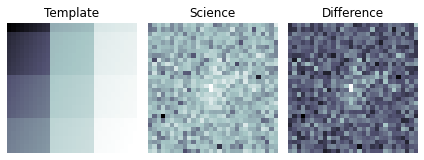

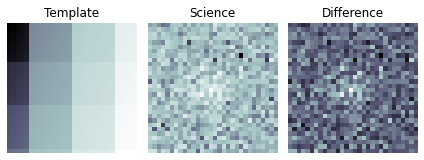

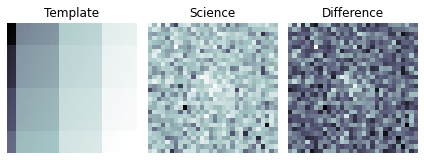

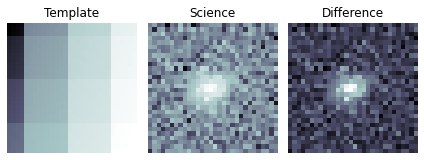

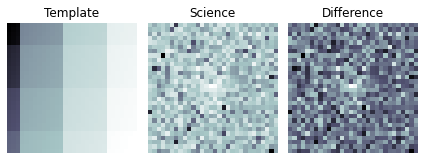

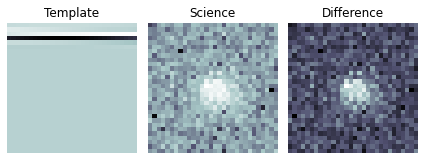

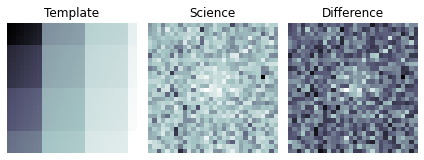

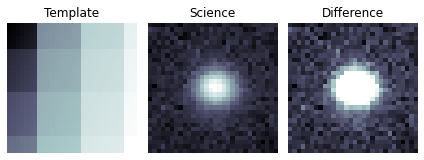

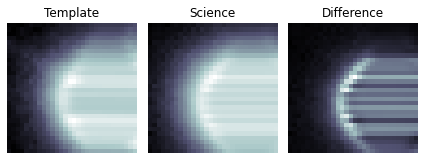

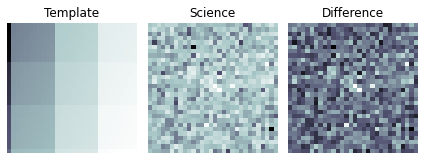

In [15]:
files = glob.glob(os.path.join(config.outputPath, "images", "*.png"))
for file in files[:10]:
    image = IPython.display.Image(file)
    IPython.display.display(image)